In [1]:
using DifferentialEquations, Parameters, ParameterizedFunctions, LinearAlgebra
using BenchmarkTools, Test, CSV, DataFrames, FastGaussQuadrature, StaticArrays
using Plots
using Revise
using Base.Threads

In [23]:
# reload after modification to module
# changes to struct will require kernel restart
includet("../src/AtomInterferometrySims_v2.jl")
using .AtomInterferometrySims_v2

### wavefront

In [3]:
# or generate a phase map

n = 1023    # number of pixel in phase map
kx = 1.e3    # spatial freq of wavefront abberation  
δ = 1*π       # phase modulation depth (-π, π)
wdw = .01  # phase map window width
pix = wdw/n  # phase map pixel size
print("pixel size: ", pix*1e6," μm")
#wdw = n * pix
xrange = LinRange(-wdw/2, wdw/2, n)
#phase_cos = repeat(δ * cos.(kx * xrange)',n,1)
phase_cos = repeat(δ * cos.(kx * xrange),1,n)
# a phase_shear can be added
A = 100 * δ
phase_shear = repeat(xrange * A, 1,n) #[15 * δ * i/n for i in 1:n,j in 1:n];

# place holder phase shear
phase_shear_null = [0*δ*i/n for i in 1:n,j in 1:n];

pixel size: 9.775171065493646 μm

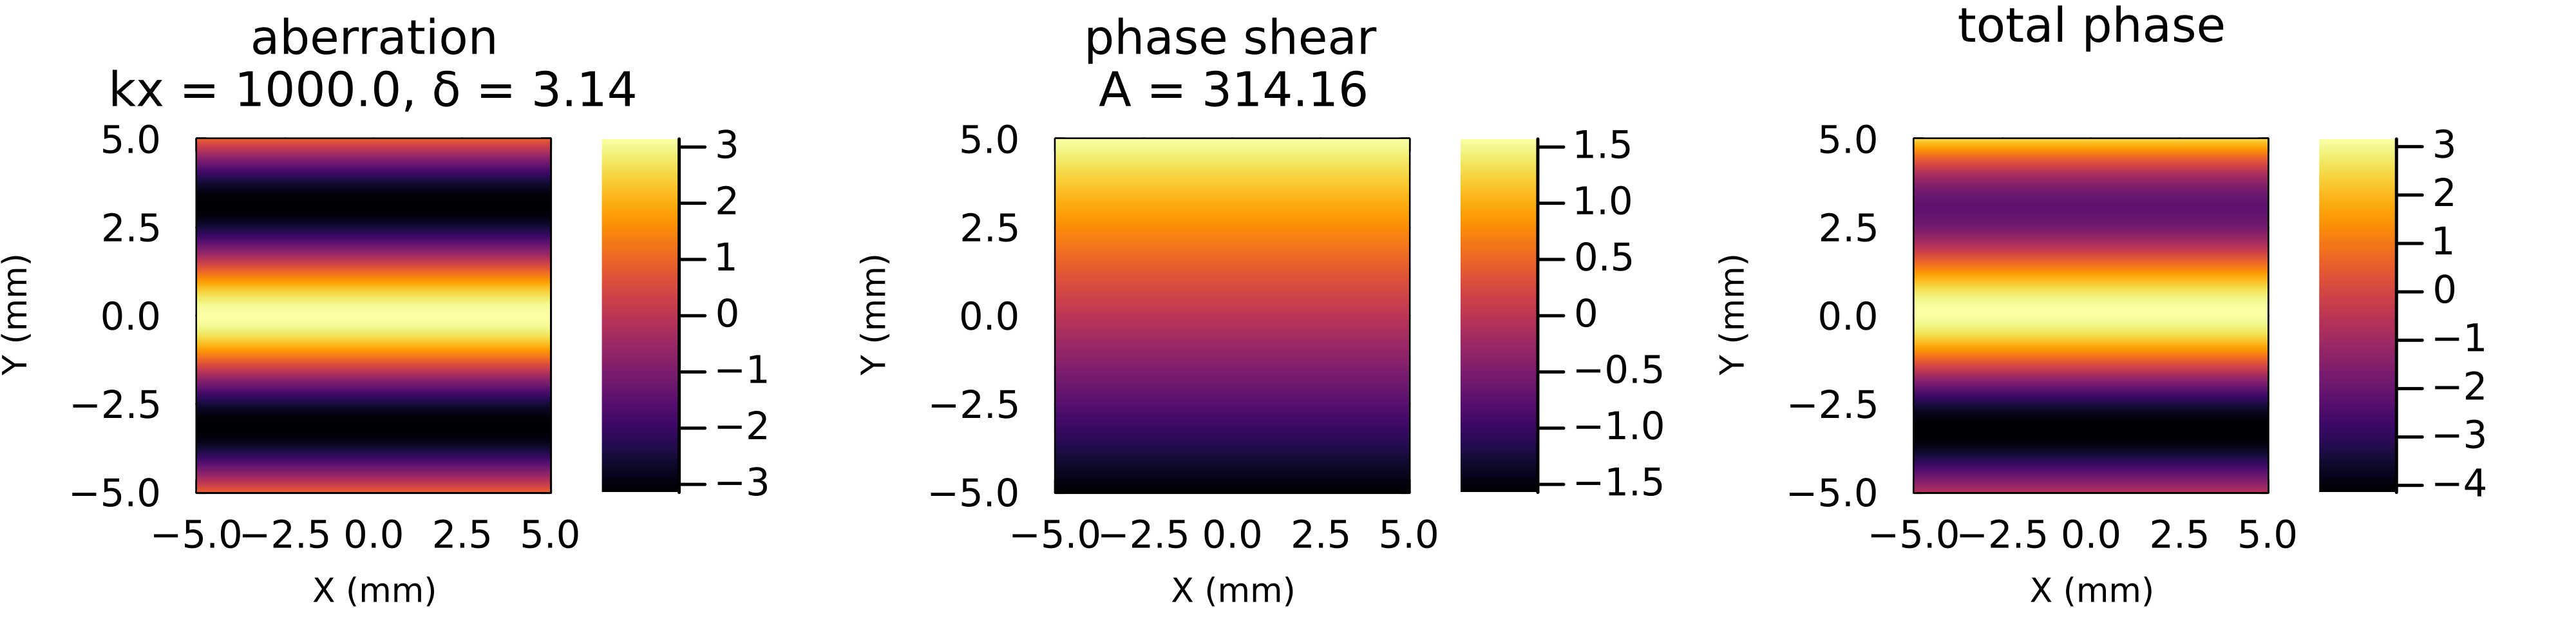

In [24]:
pPhase = plotPhase(xrange,phase_cos,kx,δ, phase_shear,A)

### Interferometry

In [5]:
num = 5000 # number of atoms

cloud_r = .8e-3  # radius of initial cloud
                 # cloud_r should ideally smaller than kx----abb feature size 
cloud_T = 6e-3  # (6 mK) initial temperatues/velocity

phase_out = Vector{Float64}(undef,num)
pos_out = Matrix{Float64}(undef,num,3)

atom_init_pos = init_pos(cloud_r,num)   # initialize atom position
atom_init_vel = init_vel(cloud_T,num)   # initialize atom velocity given temperature

seq = [[-1.,1.]] # pulse sequence

Threads.@threads for i in 1:num # evaluate each atom in parallel
    r = atom_init_pos[i,:]
    v = atom_init_vel[i,:]

    phase_out_temp, pos_out_temp = atom_phase_path_seq(seq,r,v,0.,2e-3,1,phase_cos,phase_shear_null,wdw,n)

    phase_out[i] = phase_out_temp # final phase diff info  
    pos_out[i,:] = hcat(pos_out_temp)   # final position info   
    
end


### Plot

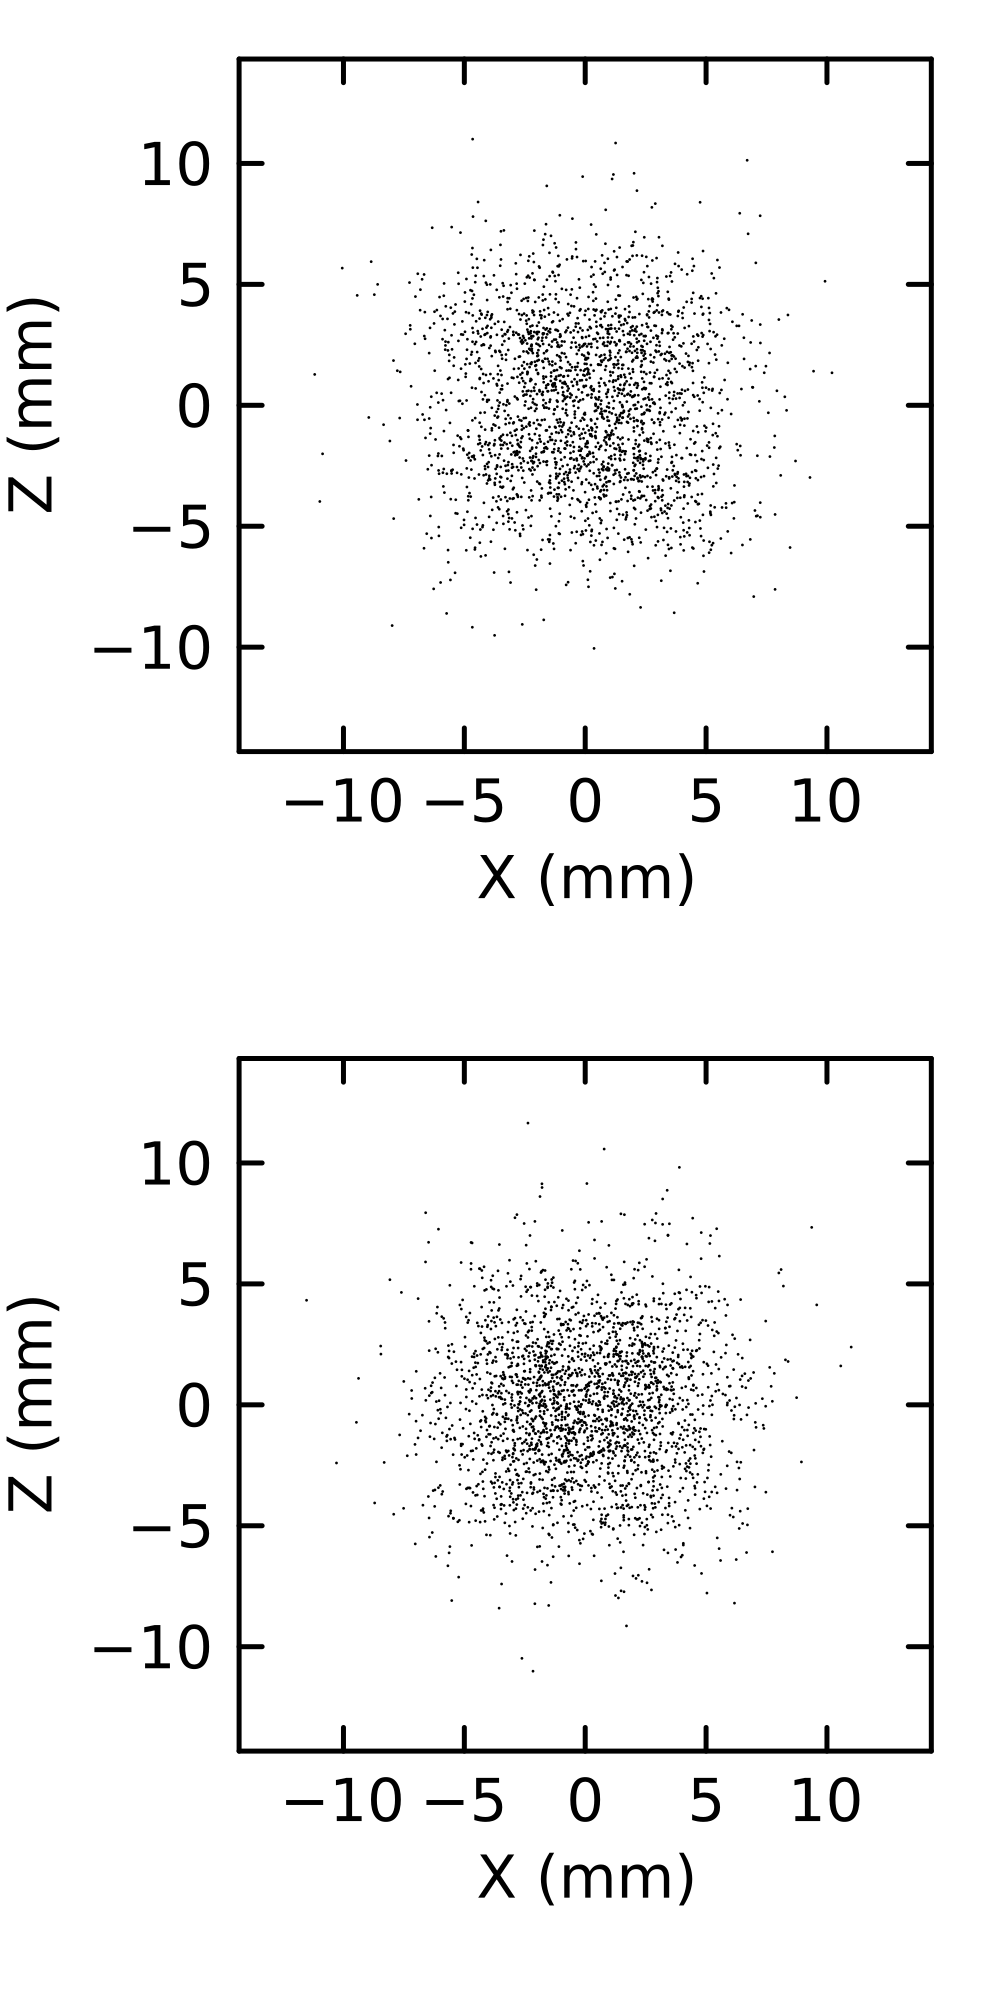

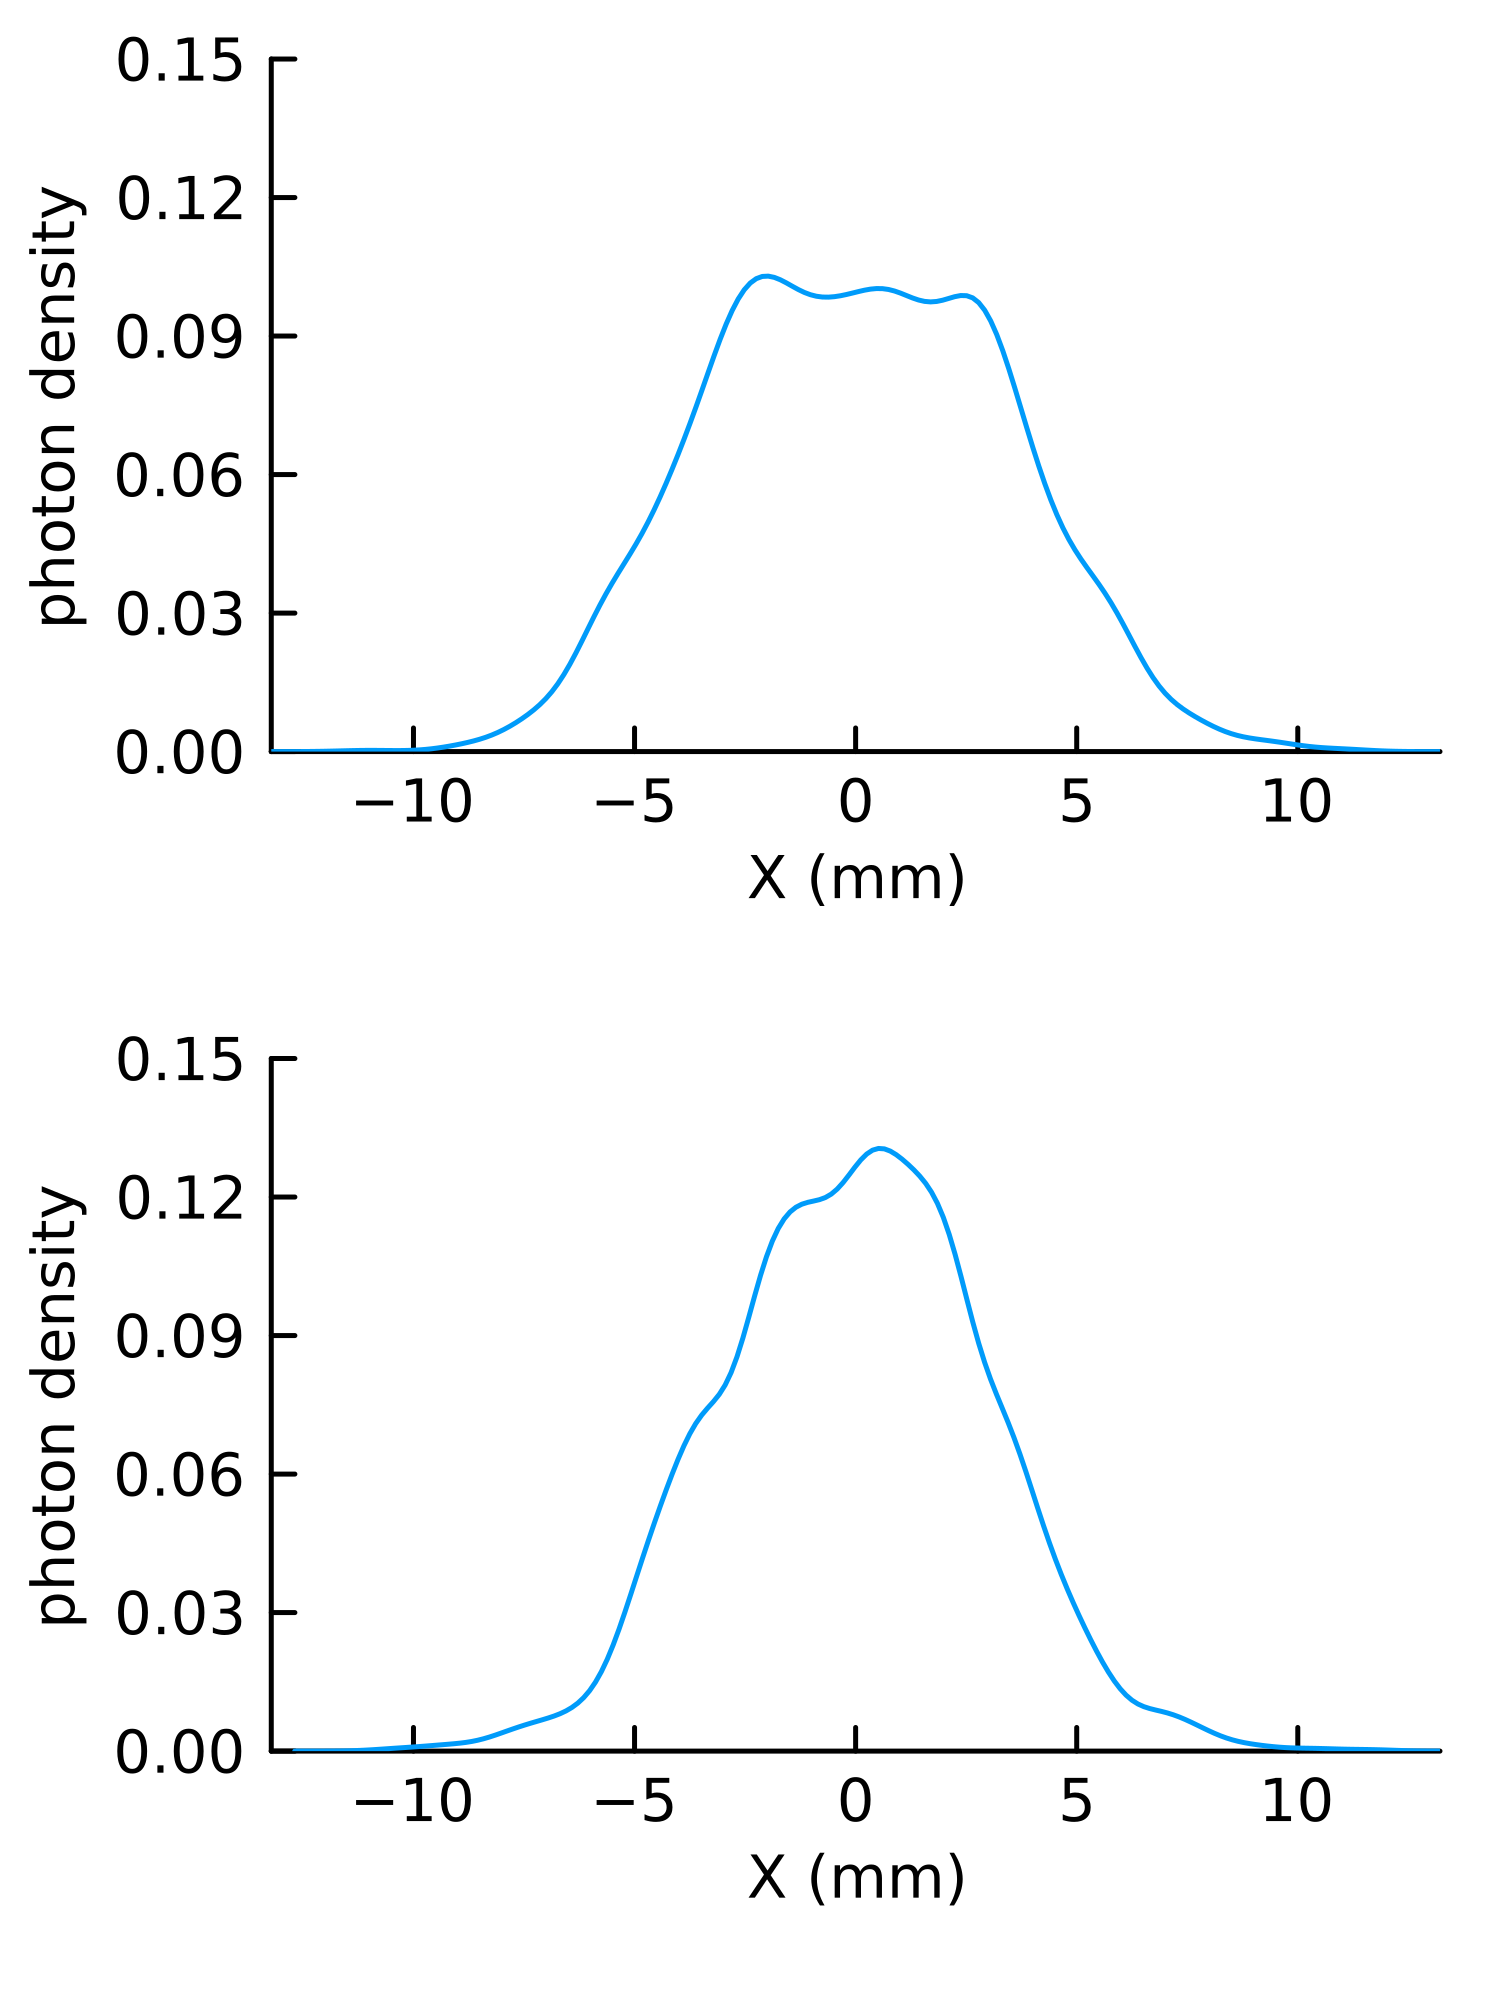

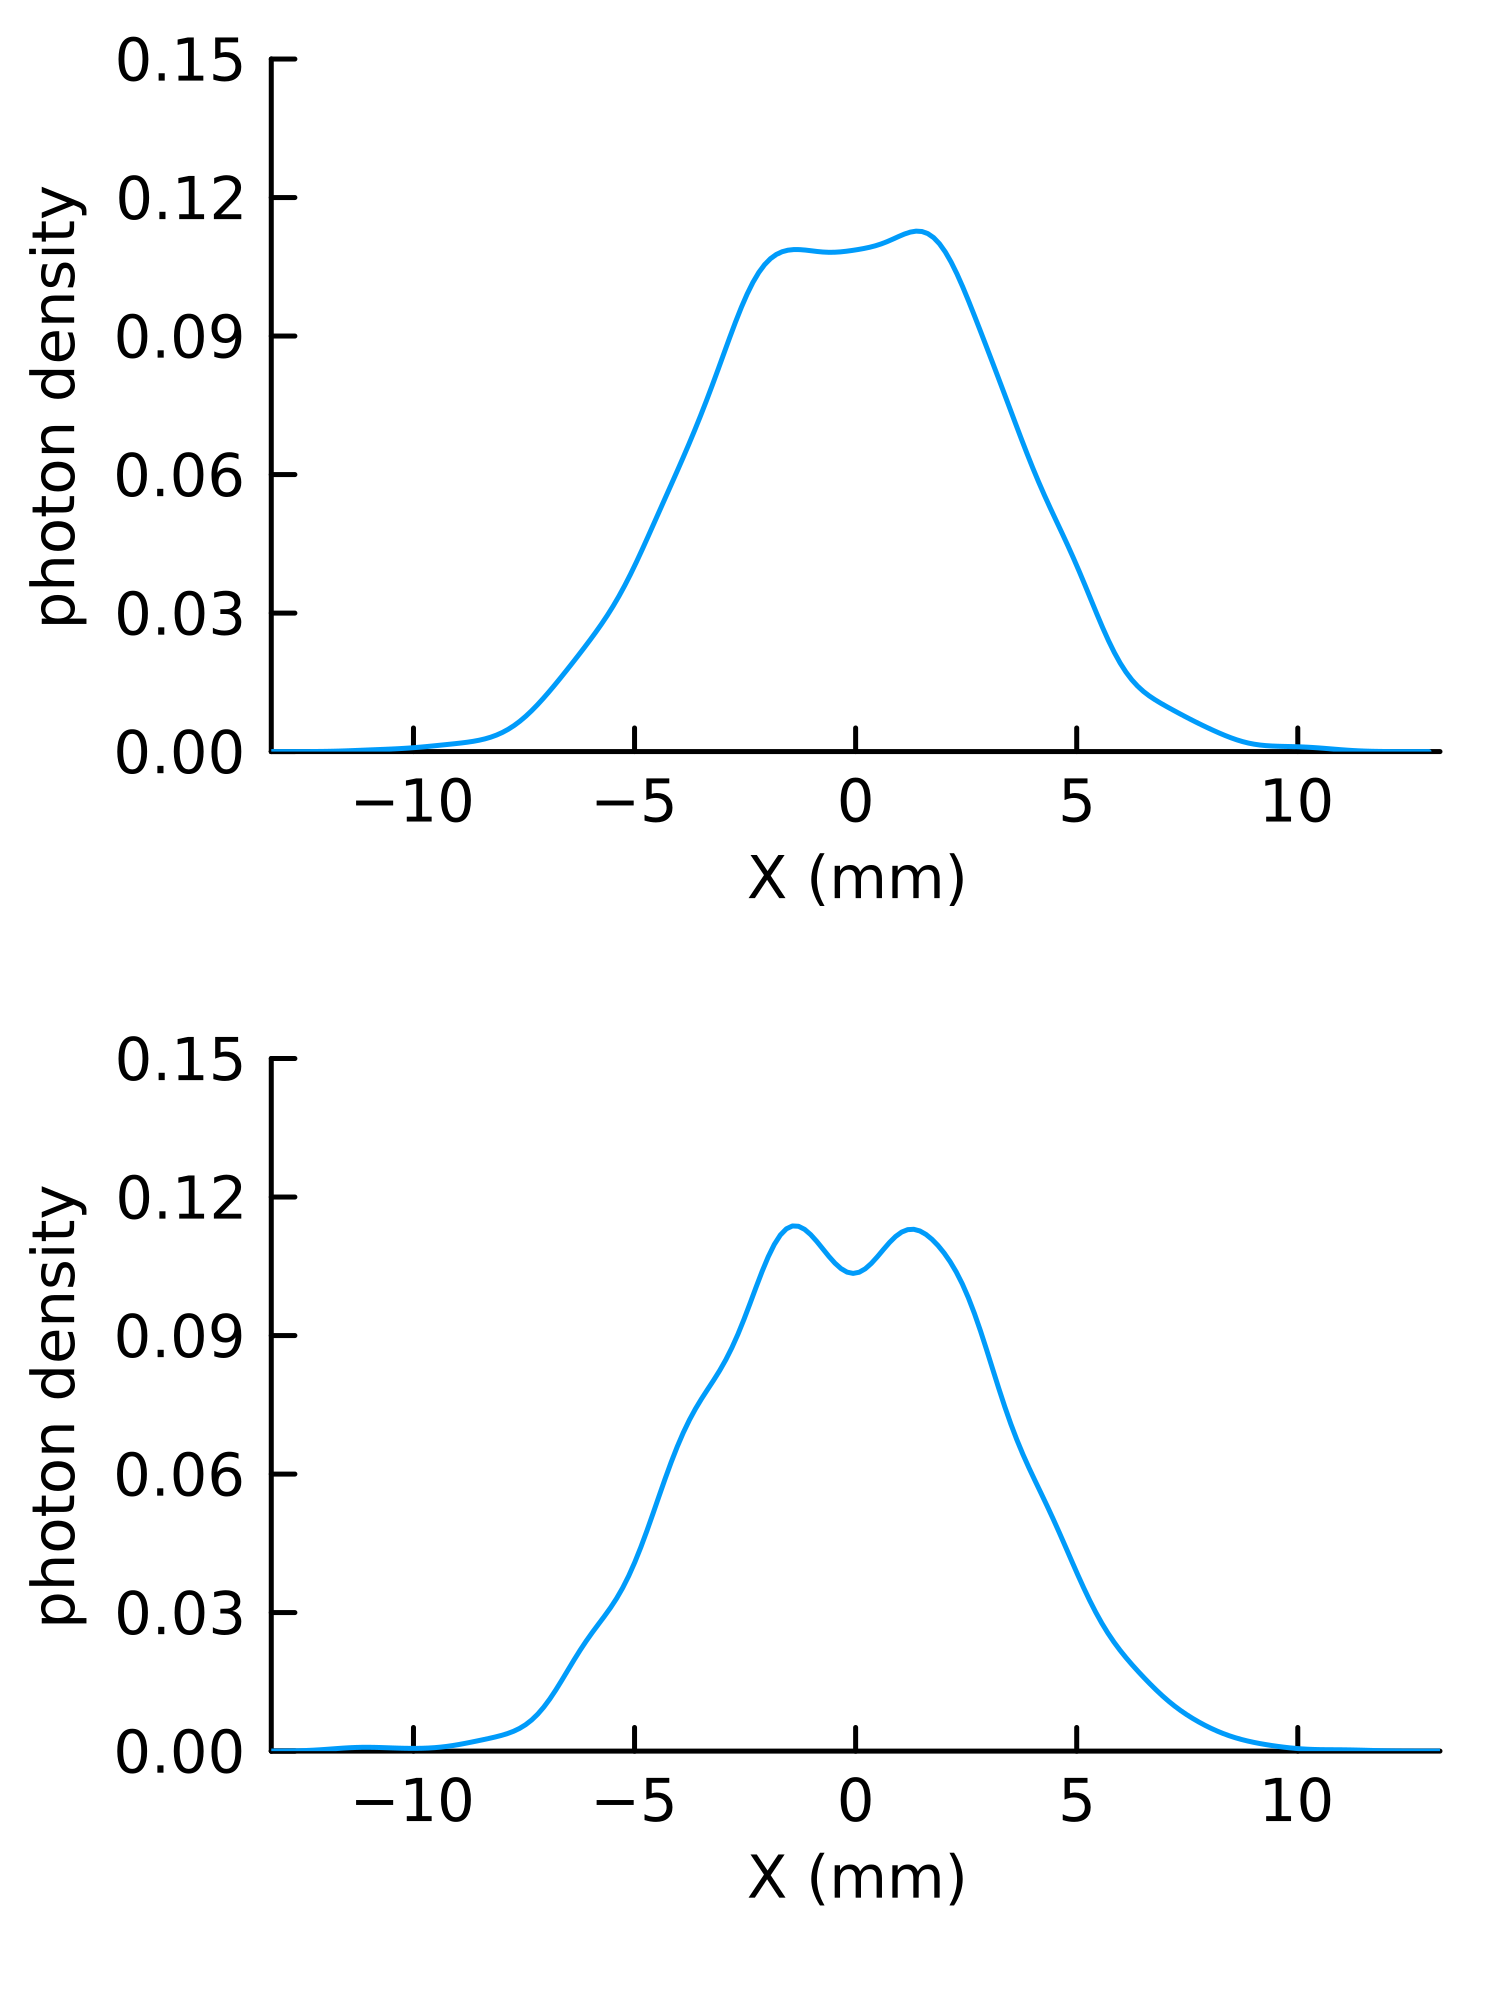

In [25]:
p2d = plot2d(pos_out,phase_out);
p1d_1 = plot1d(pos_out,phase_out,1,300);
p1d_2 = plot1d(pos_out,phase_out,2,300);

### save

In [38]:
includet("../src/sv.jl")
using .sv

In [40]:
foldername = "20240706_1"

path = pwd()*"/data/"*foldername
mkdir(path)

notes = "\nNotes:"
save_variables(joinpath(path, "var.txt"), kx, δ, A, cloud_r, cloud_T,n,notes)  
save_plots(path, pPhase,p2d,p1d_1,p1d_2)